# The Great XRFI Revamp of 2018
### Adam Beardsley



In [1]:
%matplotlib notebook
import numpy as np
from hera_qm import UVFlag
from hera_qm import xrfi
from pyuvdata import UVData
from pyuvdata import UVCal
import matplotlib.pyplot as plt
import os
from hera_qm.data import DATA_PATH
import hera_qm.utils as qm_utils
import copy
from matplotlib.colors import SymLogNorm

In [2]:
# Useful paths
data_file = '/data6/HERA/data/2458042/zen.2458042.12552.xx.HH.uv/'
data_file2 = '/data6/HERA/data/2458042/zen.2458042.13298.xx.HH.uv/'
test_outfile = '/home/beards/code/python/hera_qm/hera_qm/data/test_output/test_flags.h5'

Read in a couple data files to work with. We flag one antenna just to show we can.

In [3]:
uvd = UVData()
uvd2 = UVData()
# Downselect data for speed
uvd.read_miriad(data_file, antenna_nums=[0, 1, 11, 14, 25, 38, 70, 84, 141])
uvd2.read_miriad(data_file2, antenna_nums=[0, 1, 11, 14, 25, 38, 70, 84, 141])
# Flag one antenna for fun
uvd = xrfi.flag_xants(uvd, [0])

## The `UVFlag` object
The `UVFlag` object is intended to hold flags or statistics used to make flagging decisions. It also carries with it useful information about the associated data and a number of convenient functions. Below is a brief summary.

### Attributes
- **`mode`**: `'flag'` or `'metric'`. This determines whether the UVFlag object carries flags or significance metrics used to determine flags.<br>
- **`flag_array`**: (if `mode=='flag'`) - boolean array of flags. Shape matches data array of a UVData object, the gain array of a UVCal object, or is (time, freq, pol) if type is a waterfall (see `type` below). 
- **`metric_array`**: (if `mode=='metric'`) - float array of significance metric. Shape matches data array of a UVData object, the gain array of a UVCal object, or is (time, freq, pol) if type is a waterfall (see `type` below). 
- **`weights_array`**: float array of weights. Shape matches data array of a UVData object, the gain array of a UVCal object, or is (time, freq, pol) if type is a waterfall (see `type` below). 
- **`type`**: `'baseline'`, `'antenna'`, or `'waterfall'`. The UVFlag object either matches a `UVData` object (`'baseline'`), a `UVCal` object (`'antenna'`), or simply has frequency, time, and polarization axes.
- **`history`**: String containing history information
- **`time_array`**: Time in JD
- **`lst_array`**: LST in radians (sorry world)
- **`freq_array`**: Frequency array
- **`polarization_array`**: Array of polarization. Note this is the name, even if matching a UVCal object (which uses "jones_array").
- **`baseline_array`**: (if `type=='baseline'`)
- **`ant_1_array`**: (if `type=='baseline'`)
- **`ant_2_array`**: (if `type=='baseline'`)
- **`antenna_array`**: (if `type=='antenna'`)

### Methods
- **`read`**: Read an hdf5 file previously written by a UVFlag object.
- **`write`**: Write an hdf5 file.
- **`__eq__`**: Check equality of two UVFlag objects.
- **`__add__`**: Concatenate two UVFlag objects along given axis. Default is time axis.
- **`__iadd__`**: In place add.
- **`__or__`**: Combine two UVFlag objects in mode 'flag' by OR-ing their flags.
- **`__ior__`**: In place or
- **`clear_unused_attributes`**: Useful when changing types.
- **`copy`**: Copy a UVFlag object.
- **`to_waterfall`**: Convert to waterfall type by averaging along appropriate axis.
- **`to_baseline`**: Convert to baseline type by broadcasting along baseline axis.
- **`to_antenna`**: Convert to antenna type by broadcasting along antenna axis.
- **`to_flag`**: Convert to flag mode.
- **`to_metric`**: Convert to metric mode.
- **`antpair2ind`**: Get indices for a
- **More to come? Let me know what you want to see.**: 

Next we create our first `UVFlag` object, based on our UVData object. We note that the flag array is successfully copied from the `uvd`.

In [4]:
# Initiate a UVFlag object to match the data
uvf = UVFlag(uvd, mode='flag', copy_flags=True)
print(np.array_equal(uvd.flag_array, uvf.flag_array))

True


Or, we can create a flag object out of the two `UVData` objects right away. In this case I will not set `copy_flags`, and as a result the object will be in `metric` mode by default.

In [5]:
uvf = UVFlag([uvd, uvd2])
print('uvd.data_array shape: ', uvd.data_array.shape)
print('uvd2.data_array shape: ', uvd2.data_array.shape)
print('uvf.metric_array shape: ', uvf.metric_array.shape)

('uvd.data_array shape: ', (2700, 1, 1024, 1))
('uvd2.data_array shape: ', (2700, 1, 1024, 1))
('uvf.metric_array shape: ', (5400, 1, 1024, 1))


We can write and read the objects. The data format is hdf5, and has options for compression (default to true).

In [8]:
uvf.write(test_outfile, clobber=True)
uvf2 = UVFlag(test_outfile)  # Note we can initiate an object with a saved file.
print(uvf == uvf2)

File /home/beards/code/python/hera_qm/hera_qm/data/test_output/test_flags.h5 exists; clobbering
True


We also have functions to convert from `baseline` to `waterfall`.

In [9]:
uvf.to_waterfall()
print('uvf.metric_array shape: ', uvf.metric_array.shape)

('uvf.metric_array shape: ', (120, 1024, 1))


### XRFI Structure
The xrfi module has been completely restructured to make it easier to build sophisticated pipelines and swap in/out algorithms. Functions in `xrfi` are categorized under the following:
- Utility functions: Grab-bag for functions. Actually should probably move to `hera_qm.utils`.
 - `flag_xants`
- Preprocessing functions: Used for building up significance metrics that will be used for flagging. Typically acts on 2D arrays. There is also a dictionary, `algorithm_dict` which points to the various functions and allows us to swap out as needed.
 - `medmin`
 - `medminfilt`
 - `detrend_deriv`
 - `detrend_medminfilt`
 - `detrend_medfilt`
- Functions that loop over data to calculate metrics.
 - `calculate_metric`: Input UVData or UVCal object and a choice of algorithm, and this function will return a UVFlag object with given metric.
- Flagging algorithms: Methods for interpretting the significance metrics and making decisions on what to flag. Notably, these functions are mostly agnostic to input types, and will handle things like UVData vs UVCal and waterfalls.
 - `flag`: operates on UVFlag object in mode `metric`, given thresholds
 - `watershed_flag`: Uses UVFlag in `metric` mode to grow flags around seeds given by another UVFlag object in mode `flag`
 - `_ws_flag_waterfall`: Helper function for `watershed_flag` that operates on 2D or 1D array.
 - `flag_apply`: Takes list of UVFlag objects and applies those flags to a UVData or UVCal object.
 - `xrfi_simple`: This should die.
- Pipelines. These define the rfi strategy, connecting various pieces of the above functions.
 - `xrfi_h1c`: Example pipeline that nearly recreates what we did in H1C.
- Wrappers. These functions handle file options, etc. Contain all the nasty stuff that used to be `xrfi_run`, but is actually significantly more simple given the above structure.
 - `xrfi_h1c_run`: Recreate `xrfi_run` from H1C in all its glory.
 - `xrfi_h1c_apply`: Recreate `xrfi_apply` from H1C in most of its glory.

### Walking through a pipeline
Let's take a stroll through `xrfi_h1c`.

In [10]:
# Run detrend_medfilt. Takes about 24 seconds on enterprise
# Output is a UVFlag object in metric mode.
uvf_m = xrfi.calculate_metric(uvd, 'detrend_medfilt', Kt=8, Kf=8)

invalid value encountered in sqrt


In [11]:
# Immediately flag per pixel based on a 6-sigma threshold.
# This was previous done in watershed function
uvf = xrfi.flag(uvf_m, nsig_p=6)
# watershed -- need to give both metric and flag UVFlag objects.
uvf = xrfi.watershed_flag(uvf_m, uvf, nsig_p=2)

In [12]:
uvf_w = uvf.copy()
# Convert to waterfall by averaging flags across baseline
uvf_w.to_waterfall(method='mean')

In [13]:
# Next we flag the waterfall based on average flags
uvf_wf = xrfi.flag(uvf_w, nsig_p=0.2, nsig_f=0.05,
                   nsig_t=0.5)

<IPython.core.display.Javascript object>


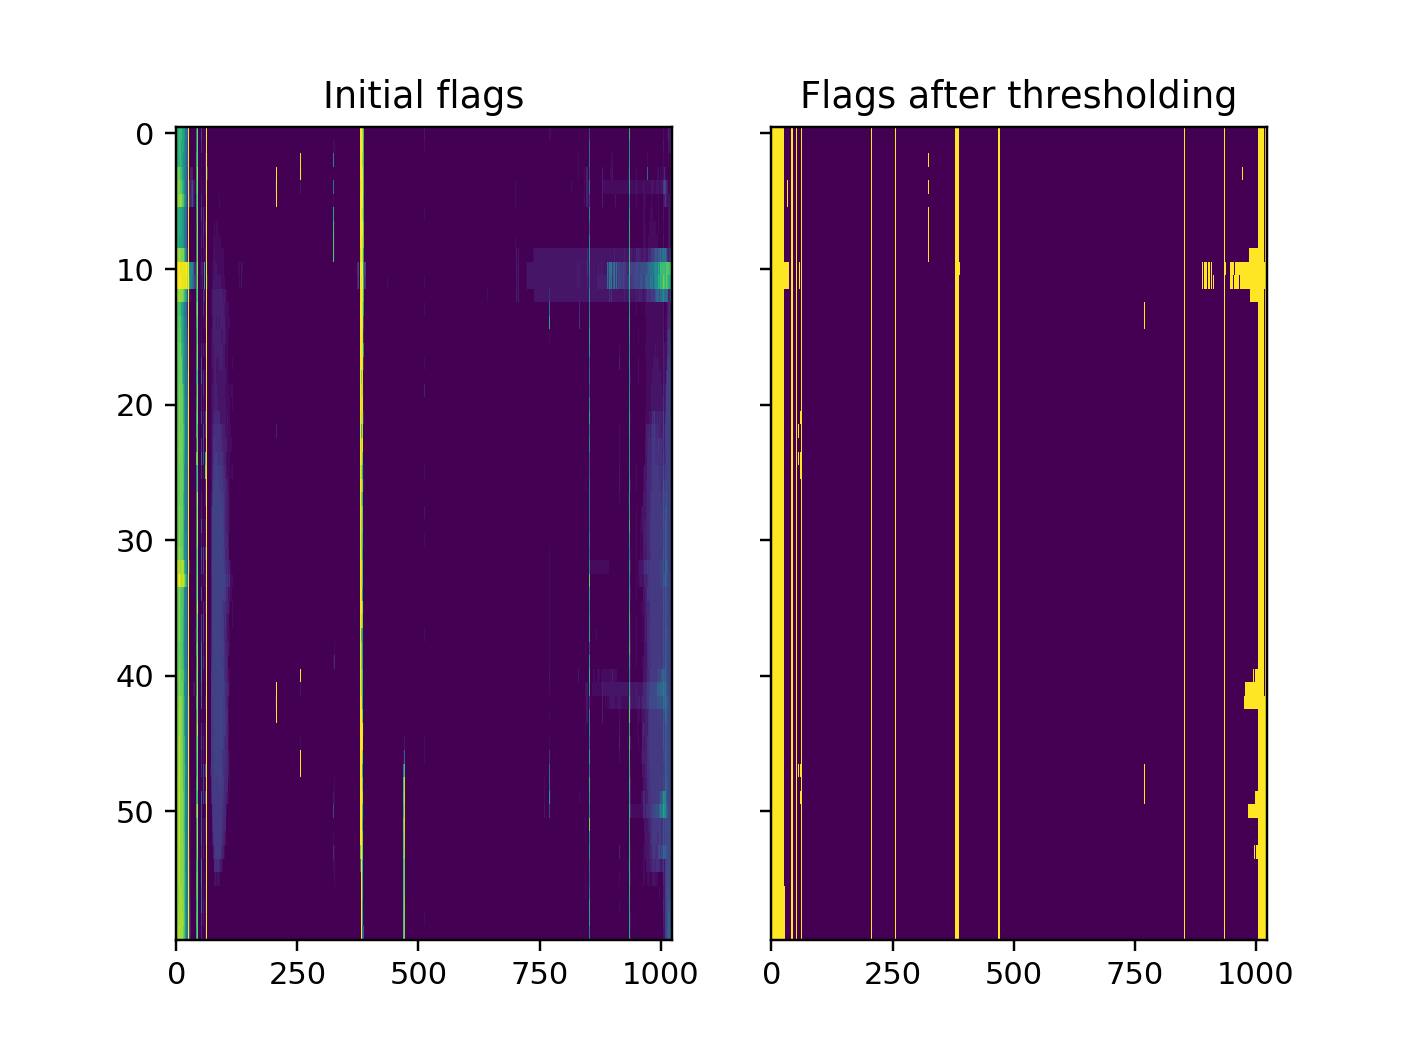

Text(0.5,1,'Flags after thresholding')

In [14]:
f, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
ax[0].imshow(uvf_w.metric_array[:, :, 0], aspect='auto', vmin=0, vmax=1)
ax[0].set_title('Initial flags')
ax[1].imshow(uvf_wf.flag_array[:, :, 0], aspect='auto', vmin=0, vmax=1)
ax[1].set_title('Flags after thresholding')

In [ ]:
# Let's build a new pipeline
